In [1]:
#devtools::install_github("immunogenomics/lisi")

### Compare the LISI integration metrics across methods

In [2]:
library(lisi)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
adata_metadata = read.csv("05_adata_metadata_for_LISI.csv")

In [4]:
adata_metadata %>% head()

,X,index,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,⋯,leiden_scVI,scvi_cell_type,scvi_UMAP1,scvi_UMAP2,CellANOVA_UMAP1,CellANOVA_UMAP2,harmony_UMAP1,harmony_UMAP2,no_integration_UMAP1,no_integration_UMAP2
,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,HCAHeart7656534_GACGCGTAGAGGGCTT-1,57.5,D3-Cell_3prime-v2,male,LV,Mural cell,Pericyte,Teichman,3prime-v2,⋯,0,Pericyte,5.231465,-6.991966,10.412267,8.415722,15.270932,-3.609832,-1.703305,10.611344
2,1,HCAHeart7656534_CCTAGCTCATTGGCGC-1,57.5,D3-Cell_3prime-v2,male,LV,Endothelial cell,Endothelial,Teichman,3prime-v2,⋯,2,Endothelial,12.757141,15.418440,-6.296615,4.096263,11.673471,10.608384,-4.585667,-2.127161
3,2,HCAHeart7656534_TCTTTCCAGCCCAGCT-1,57.5,D3-Cell_3prime-v2,male,LV,Endothelial cell,Endothelial,Teichman,3prime-v2,⋯,2,Endothelial,14.163062,14.003044,3.234175,1.813514,12.565978,11.594909,-3.172797,-1.711793
4,3,HCAHeart7656534_TGACTAGTCAACGAAA-1,57.5,D3-Cell_3prime-v2,male,LV,Endothelial cell,Endothelial,Teichman,3prime-v2,⋯,4,Endothelial,10.201986,15.218262,-3.745589,4.424518,13.820744,10.044436,-3.386531,-1.704148
5,4,HCAHeart7656534_GCGCAACAGGGAACGG-1,57.5,D3-Cell_3prime-v2,male,LV,Endothelial cell,Endothelial,Teichman,3prime-v2,⋯,4,Endothelial,10.801823,15.370571,-4.805147,4.949536,13.748776,10.087685,-2.772270,-1.856993
6,5,HCAHeart7656534_TCGAGGCCACAGTCGC-1,57.5,D3-Cell_3prime-v2,male,LV,Fibroblast,Fibroblast,Teichman,3prime-v2,⋯,7,Fibroblast,14.308776,-2.932476,11.412273,18.323757,1.190965,-1.171608,5.991797,13.030653


In [5]:
# number of studies
length(unique(adata_metadata$study))

[1] 12

In [6]:
compute_LISI <- function(adata_metadata, UMAP_1_name, UMAP_2_name, integration_method) {

    # compute the LISI for study and cell type
    # inputs are the adata_metadata, which should have all of the columns
    # UMAP_1_name and UMAP_2_name are the strings for the UMAP1 and UMAP2 coordinates 
    # integration method is the name of the integration method (e.g.  "harmony")

    # filter the metadata
    X <- adata_metadata[ , c(UMAP_1_name, UMAP_2_name)]
    meta_data <- adata_metadata[, c("study", "consistent_cell_type", "cell_or_nuclei", "donor_id")]

    # compute the LISI for these two metadata columns
    res <- compute_lisi(X, meta_data, c("study", "consistent_cell_type", "cell_or_nuclei", "donor_id"))

    # pivot this longer 
    res <- res %>% pivot_longer(cols = everything(), names_to = "category", values_to = "lisi")
    res$integration_method <- integration_method

    return(res)
}

### For each integration metric, calculate LISI

In [7]:
scvi_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "scvi_UMAP1", 
                        UMAP_2_name = "scvi_UMAP2", 
                        integration_method = "scvi")

In [8]:
cellanova_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "CellANOVA_UMAP1", 
                        UMAP_2_name = "CellANOVA_UMAP2", 
                        integration_method = "CellANOVA")

In [9]:
harmony_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "harmony_UMAP1", 
                        UMAP_2_name = "harmony_UMAP2", 
                        integration_method = "harmony")

In [10]:
no_integration_results <- compute_LISI(adata_metadata = adata_metadata,
                        UMAP_1_name = "no_integration_UMAP1", 
                        UMAP_2_name = "no_integration_UMAP2", 
                        integration_method = "no integration")

### Plot the performance in terms of integration by study (higher is better) and integration by cell_type (lower is better)

In [11]:
combined_results <- rbind(scvi_results, cellanova_results)
combined_results <- rbind(combined_results, harmony_results)
combined_results <- rbind(combined_results, no_integration_results)

In [12]:
combined_results$integration_method <- factor(combined_results$integration_method , c("CellANOVA", "scvi", "harmony", "no integration"))

In [13]:
plots_dir <- "LISI_plots/"
dir.create(plots_dir)

Warning message in dir.create(plots_dir):
“'LISI_plots' already exists”


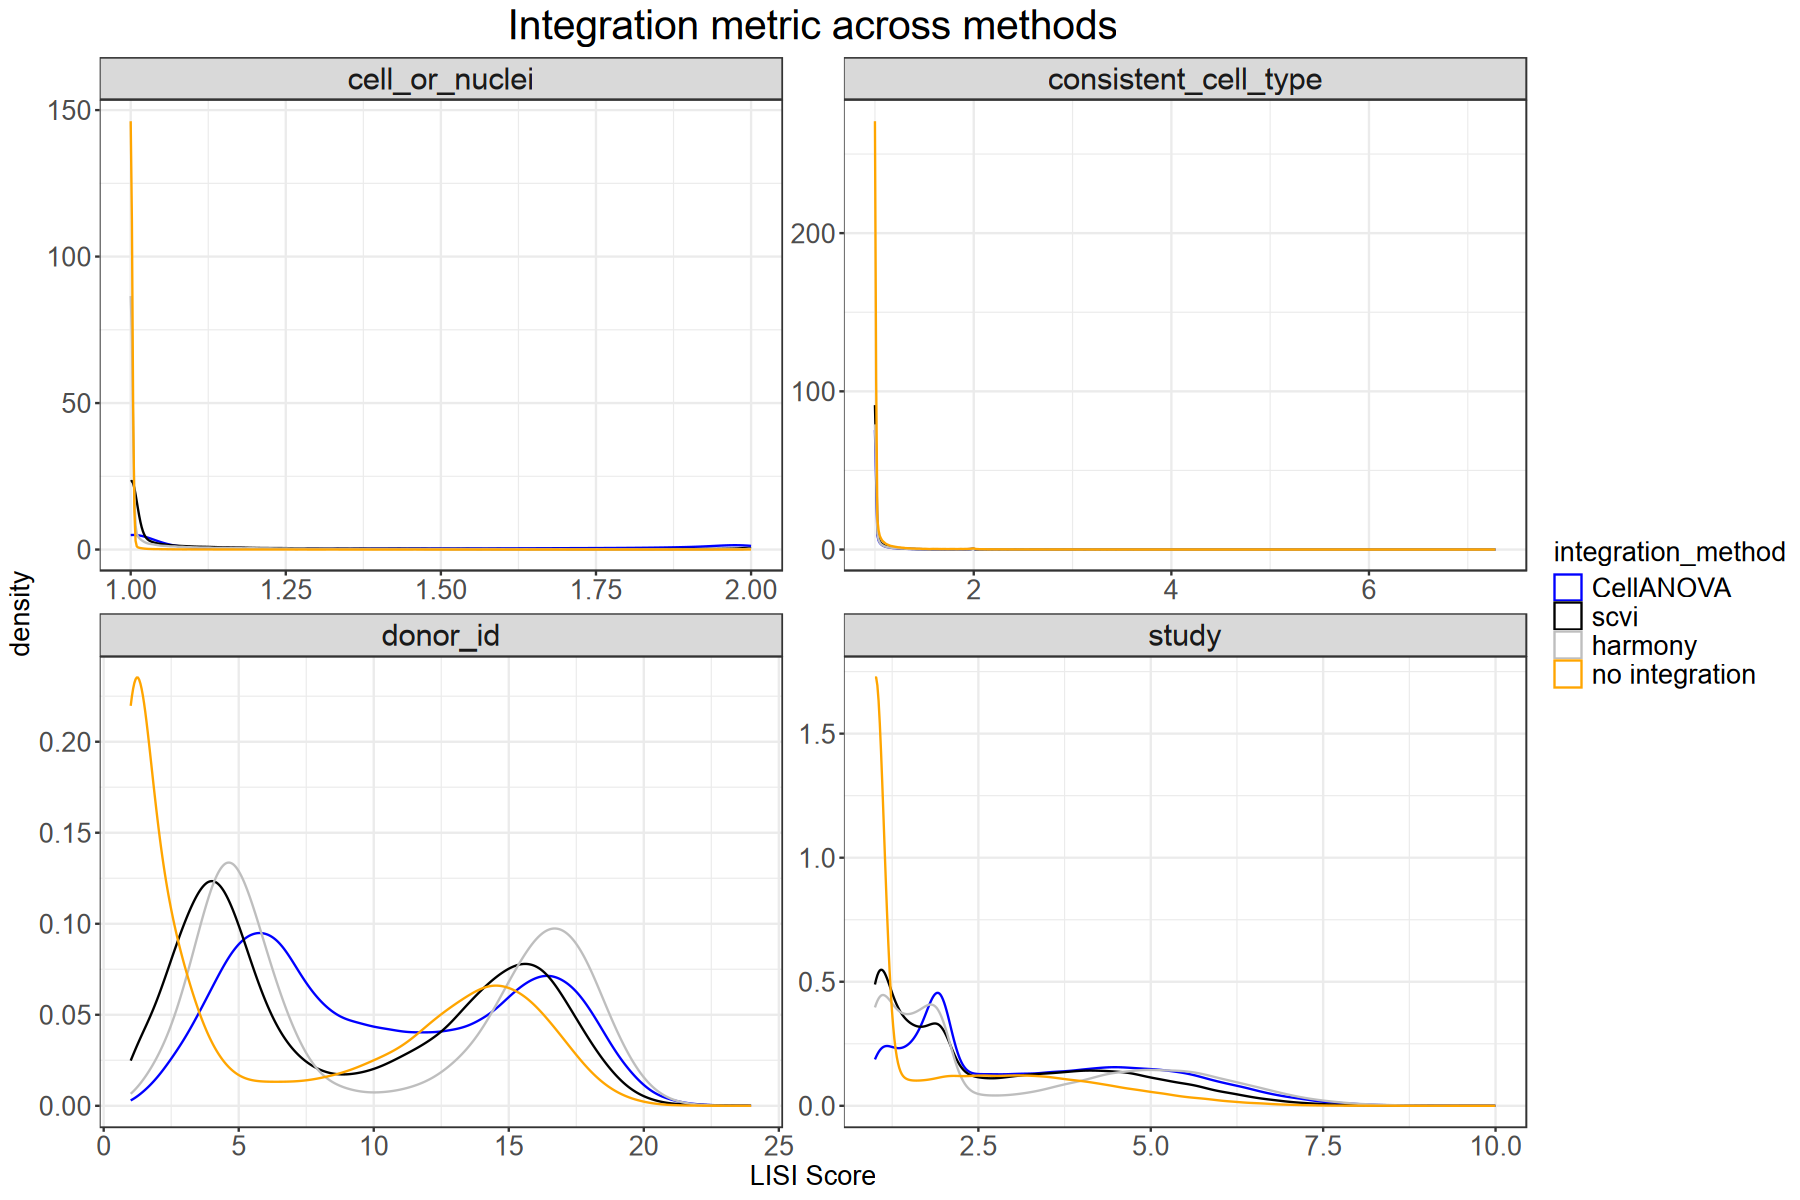

In [14]:
options(repr.plot.width = 15, repr.plot.height = 10)

custom_colors <- c(
  "CellANOVA" = "blue",  
  "scvi" = "black",  
  "harmony" = "gray",
  "no integration" = "orange"
)

p1 <- ggplot(data = combined_results, mapping = aes(x = lisi, color = integration_method)) + 
    geom_density(alpha = 0.5, linewidth = 0.5) + 
    facet_wrap(~ category, scales = "free") + 
    theme_bw() +
    labs(x = "LISI Score", y = "density", title = "Integration metric across methods") +
    theme(legend.position = "right") + 
    theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 18)) + 
    scale_color_manual(values = custom_colors)
    
p1

ggsave(p1, filename = paste0(plots_dir, "sc_vs_sn_LISI_across_studies.pdf"), units = "in", width = 15, height = 5)